**Identifying the most "valuable" player based on advanced statistics and analysis**

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
color = sns.color_palette()
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

/root/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pie_df = pd.read_csv("../2017_NBA_MVP/nba_2017_pie.csv")
pie_df = pie_df.query('GP>50')
#Filter for players who have played more than 50 games
pie_df = pie_df.query('MIN>25')
#Filter for players who average more than 25 minutes a game
pie_df = pie_df.query('PIE>12')
#Filter players with a significant contribution/usage rate
pie_df.head()

,PLAYER,TEAM,AGE,GP,W,L,MIN,OFFRTG,DEFRTG,NETRTG,...,AST RATIO,OREB%,DREB%,REB%,TO RATIO,EFG%,TS%,USG%,PACE,PIE
0,Russell Westbrook,OKC,28,81,46,35,34.6,107.9,104.6,3.3,...,23.4,5.3,27.9,16.7,12.2,47.6,55.4,40.8,102.31,23.0
3,Anthony Davis,NOP,24,75,31,44,36.1,104.2,102.5,1.7,...,7.3,6.7,26.9,17.0,8.4,51.8,58.0,32.6,100.19,19.2
4,James Harden,HOU,27,81,54,27,36.4,113.6,107.3,6.3,...,27.6,3.5,21.2,12.3,14.1,52.5,61.3,34.1,102.98,19.0
5,Kevin Durant,GSW,28,62,51,11,33.4,117.2,101.3,16.0,...,18.4,2.3,23.2,13.7,8.5,59.4,65.1,27.6,103.71,18.6
6,LeBron James,CLE,32,74,51,23,37.8,114.9,107.1,7.7,...,25.6,4.0,20.9,12.7,12.0,59.4,61.9,29.7,98.38,18.3


In [3]:
plus_minus_df = pd.read_csv("../2017_NBA_MVP/nba_2017_real_plus_minus.csv")
plus_minus_df = plus_minus_df.query('GP>50')
#Filter for players who have played more than 50 games
plus_minus_df = plus_minus_df.query('MPG>25')
#Filter for players who average more than 25 minutes a game
plus_minus_df.head()

,NAME,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS
0,"LeBron James, SF",CLE,74,37.8,6.49,1.93,8.42,20.43
1,"Stephen Curry, PG",GS,79,33.4,7.27,0.14,7.41,18.80
2,"Jimmy Butler, SG",CHI,76,37.0,4.82,1.80,6.62,17.35
3,"Russell Westbrook, PG",OKC,81,34.6,6.74,-0.47,6.27,17.34
4,"Draymond Green, PF",GS,76,32.5,1.55,5.59,7.14,16.84


In [4]:
br_stats_df = pd.read_csv("../2017_NBA_MVP/nba_2017_br.csv")
br_stats_df = br_stats_df.query('G>50')
#Filter for players who have played more than 50 games
br_stats_df = br_stats_df.query('MP>25')
#Filter for players who average more than 25 minutes a game
br_stats_df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,1,Russell Westbrook,PG,28,OKC,81,81,34.6,10.2,24.0,...,0.845,1.7,9.0,10.7,10.4,1.6,0.4,5.4,2.3,31.6
1,2,James Harden,PG,27,HOU,81,81,36.4,8.3,18.9,...,0.847,1.2,7.0,8.1,11.2,1.5,0.5,5.7,2.7,29.1
2,3,Isaiah Thomas,PG,27,BOS,76,76,33.8,9.0,19.4,...,0.909,0.6,2.1,2.7,5.9,0.9,0.2,2.8,2.2,28.9
3,4,Anthony Davis,C,23,NOP,75,75,36.1,10.3,20.3,...,0.802,2.3,9.5,11.8,2.1,1.3,2.2,2.4,2.2,28.0
4,5,DeMar DeRozan,SG,27,TOR,74,74,35.4,9.7,20.9,...,0.842,0.9,4.3,5.2,3.9,1.1,0.2,2.4,1.8,27.3


In [5]:
plus_minus_df.rename(columns={"NAME":"PLAYER", "WINS": "WINS_RPM"}, inplace=True)
players = []
for player in plus_minus_df["PLAYER"]:
    plyr, _ = player.split(",")
    players.append(plyr)
plus_minus_df.drop(["PLAYER"], inplace=True, axis=1)
plus_minus_df["PLAYER"] = players
plus_minus_df.head()

,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS_RPM,PLAYER
0,CLE,74,37.8,6.49,1.93,8.42,20.43,LeBron James
1,GS,79,33.4,7.27,0.14,7.41,18.80,Stephen Curry
2,CHI,76,37.0,4.82,1.80,6.62,17.35,Jimmy Butler
3,OKC,81,34.6,6.74,-0.47,6.27,17.34,Russell Westbrook
4,GS,76,32.5,1.55,5.59,7.14,16.84,Draymond Green


In [6]:
nba_players_df = br_stats_df.copy()
nba_players_df.rename(columns={'Player': 'PLAYER','Pos':'POSITION', 'Tm': "TEAM", 'Age': 'AGE', 'TRB': 'REB', "PS/G": "PPG"}, inplace=True)
nba_players_df.drop(["Rk","G", "GS", "TEAM", "POSITION", "AGE", "2P", "2PA", "2P%","3P", "3PA", "3P%", "eFG%","PF", "ORB", "DRB"], inplace=True, axis=1)
nba_players_df = nba_players_df.merge(plus_minus_df, how="inner", on="PLAYER")
nba_players_df.head()

,PLAYER,MP,FG,FGA,FG%,FT,FTA,FT%,REB,AST,...,BLK,TOV,PPG,TEAM,GP,MPG,ORPM,DRPM,RPM,WINS_RPM
0,Russell Westbrook,34.6,10.2,24.0,0.425,8.8,10.4,0.845,10.7,10.4,...,0.4,5.4,31.6,OKC,81,34.6,6.74,-0.47,6.27,17.34
1,James Harden,36.4,8.3,18.9,0.440,9.2,10.9,0.847,8.1,11.2,...,0.5,5.7,29.1,HOU,81,36.4,6.38,-1.57,4.81,15.54
2,Isaiah Thomas,33.8,9.0,19.4,0.463,7.8,8.5,0.909,2.7,5.9,...,0.2,2.8,28.9,BOS,76,33.8,5.72,-3.89,1.83,8.19
3,Anthony Davis,36.1,10.3,20.3,0.505,6.9,8.6,0.802,11.8,2.1,...,2.2,2.4,28.0,NO,75,36.1,0.45,3.90,4.35,12.81
4,DeMar DeRozan,35.4,9.7,20.9,0.467,7.4,8.7,0.842,5.2,3.9,...,0.2,2.4,27.3,TOR,74,35.4,2.21,-2.04,0.17,5.46


In [7]:
pie_df_subset = pie_df[["PLAYER", "NETRTG", "AST%", "AST/TO","REB%", "USG%", "TS%", "W"]].copy()
nba_players_df = nba_players_df.merge(pie_df_subset, how="inner", on="PLAYER")
nba_players_df.drop(["ORPM","DRPM" ], inplace=True, axis=1)
nba_players_df.head()

,PLAYER,MP,FG,FGA,FG%,FT,FTA,FT%,REB,AST,...,MPG,RPM,WINS_RPM,NETRTG,AST%,AST/TO,REB%,USG%,TS%,W
0,Russell Westbrook,34.6,10.2,24.0,0.425,8.8,10.4,0.845,10.7,10.4,...,34.6,6.27,17.34,3.3,54.3,1.92,16.7,40.8,55.4,46
1,James Harden,36.4,8.3,18.9,0.440,9.2,10.9,0.847,8.1,11.2,...,36.4,4.81,15.54,6.3,50.5,1.95,12.3,34.1,61.3,54
2,Isaiah Thomas,33.8,9.0,19.4,0.463,7.8,8.5,0.909,2.7,5.9,...,33.8,1.83,8.19,5.0,30.5,2.13,4.5,33.7,62.5,51
3,Anthony Davis,36.1,10.3,20.3,0.505,6.9,8.6,0.802,11.8,2.1,...,36.1,4.35,12.81,1.7,11.0,0.87,17.0,32.6,58.0,31
4,DeMar DeRozan,35.4,9.7,20.9,0.467,7.4,8.7,0.842,5.2,3.9,...,35.4,0.17,5.46,3.3,20.4,1.61,8.3,34.2,55.2,47


/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


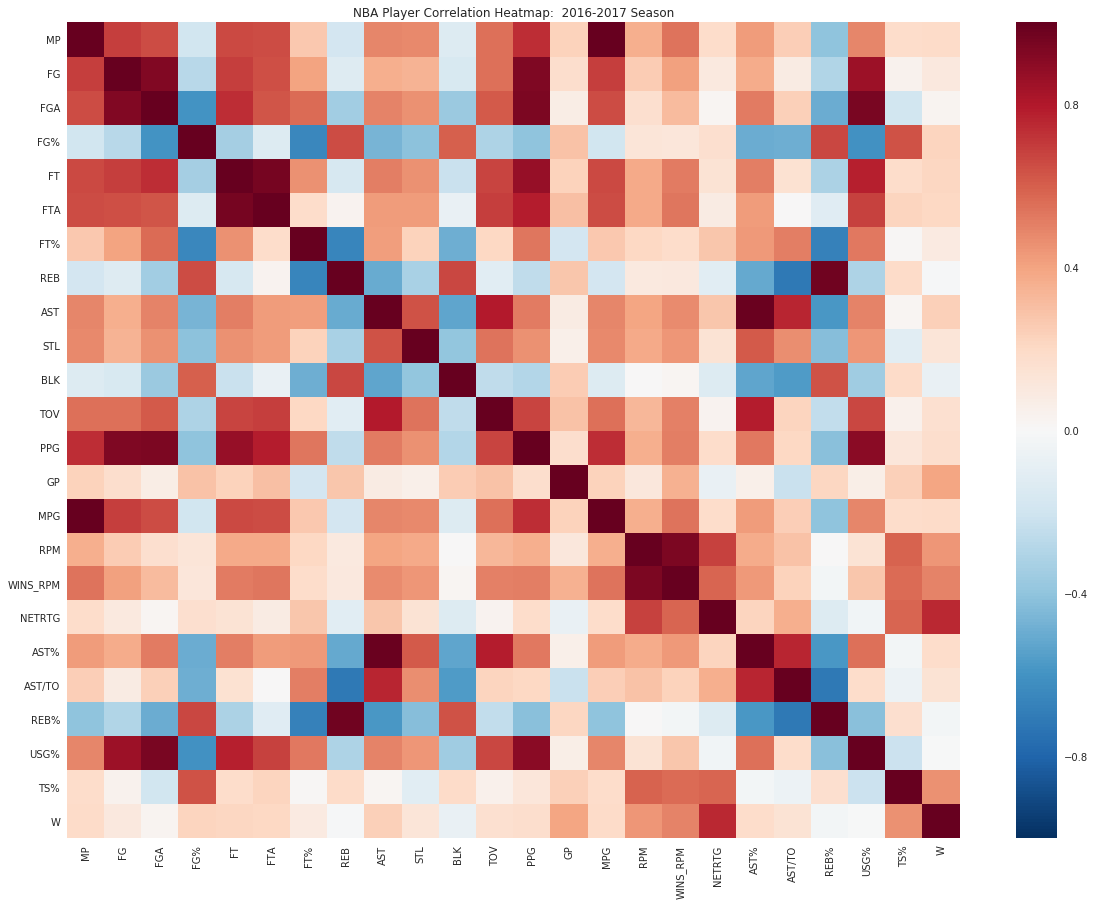

In [8]:
plt.subplots(figsize=(20,15))
ax = plt.axes()
ax.set_title("NBA Player Correlation Heatmap:  2016-2017 Season")
corr = nba_players_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

From the heatmap, we can see that **Net Rating (NETRTG)** is most correlated to **wins**

/root/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


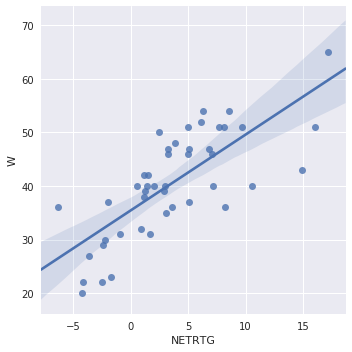

In [9]:
#Run a scatterplot to visualize this relationship
sns.lmplot(x="NETRTG", y="W", data=nba_players_df)

In [10]:
#Perform linear regression to confirm this relationship
results = smf.ols('W ~NETRTG', data=nba_players_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     56.62
Date:                Tue, 22 Jan 2019   Prob (F-statistic):           2.26e-09
Time:                        03:14:40   Log-Likelihood:                -147.22
No. Observations:                  45   AIC:                             298.4
Df Residuals:                      43   BIC:                             302.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.4278      1.186     29.878      0.0

***The regression formula showed a positive relationship between players' net rating and wins***

In [11]:
#Further review top 25 players' value from Net Rating
nba_players_df.nlargest(25,'NETRTG')

,PLAYER,MP,FG,FGA,FG%,FT,FTA,FT%,REB,AST,...,MPG,RPM,WINS_RPM,NETRTG,AST%,AST/TO,REB%,USG%,TS%,W
9,Stephen Curry,33.4,8.5,18.3,0.468,4.1,4.6,0.898,4.5,6.6,...,33.4,7.41,18.80,17.2,28.7,2.19,7.3,29.2,62.4,65
11,Kevin Durant,33.4,8.9,16.5,0.537,5.4,6.2,0.875,8.3,4.8,...,33.4,5.74,12.24,16.0,21.8,2.17,13.7,27.6,65.1,51
30,Chris Paul,31.5,6.1,12.9,0.476,3.8,4.3,0.892,5.0,9.2,...,31.5,7.92,13.48,14.9,44.4,3.83,8.9,24.3,61.4,43
20,Blake Griffin,34.0,7.9,15.9,0.493,5.2,6.9,0.760,8.1,4.9,...,34.0,3.78,9.20,10.6,23.5,2.11,13.7,27.8,56.9,40
42,DeAndre Jordan,31.7,5.1,7.1,0.714,2.5,5.2,0.482,13.8,1.2,...,31.7,4.55,12.59,9.7,5.4,0.83,24.3,15.3,67.3,51
8,Kawhi Leonard,33.4,8.6,17.7,0.485,6.3,7.2,0.880,5.8,3.5,...,33.4,7.08,15.53,8.6,18.2,1.69,10.0,31.2,61.0,54
18,Kyle Lowry,37.4,7.1,15.3,0.464,5.0,6.1,0.819,4.8,7.0,...,37.4,5.88,12.67,8.2,29.3,2.41,7.3,24.9,62.3,36
38,Rudy Gobert,33.9,5.1,7.7,0.661,3.8,5.9,0.653,12.8,1.2,...,33.9,6.37,15.55,8.1,5.7,0.66,21.7,16.7,68.1,51
7,LeBron James,37.8,9.9,18.2,0.548,4.8,7.2,0.674,8.6,8.7,...,37.8,8.42,20.43,7.7,38.8,2.13,12.7,29.7,61.9,51
27,Kevin Love,31.4,6.2,14.5,0.427,4.3,4.9,0.871,11.1,1.9,...,31.4,5.03,9.76,7.2,9.3,0.95,19.3,25.5,57.3,40


To assess for the **Most *Valuable* player,** I will look to gauge their individual *value* to a team. To do so I will remove players on this list from the **same team** since their Net Rating (NETRTG) is affected by teammates on this list

In [12]:
nba_players_df['TEAM'].value_counts()

CLE       3
LAC       3
TOR       3
SA        3
MIL       2
UTAH      2
ATL       2
CHI       2
MIA       2
GS        2
BOS       2
MEM       2
IND       2
NO        2
DEN       1
PHX       1
WSH       1
POR       1
ORL       1
NO/SAC    1
DAL       1
MIN       1
HOU       1
CHA       1
OKC       1
DET       1
BKN       1
Name: TEAM, dtype: int64

The output list shows a number of **teams with multiple players** who qualified for both a **significant amount of playing time** (Minutes and Game played) and **contribution of possession** (PIE)

In [13]:
nba_players_df.drop_duplicates(subset ="TEAM", 
                     keep = False, inplace = True) 
#This new dataset will identify players with more individual contribution to team
nba_players_df.drop(["FG","FGA", "FG%", "FT", "FTA", "FT%"], inplace=True, axis=1)
nba_players_df.nlargest(15,'NETRTG')

,PLAYER,MP,REB,AST,STL,BLK,TOV,PPG,TEAM,GP,MPG,RPM,WINS_RPM,NETRTG,AST%,AST/TO,REB%,USG%,TS%,W
1,James Harden,36.4,8.1,11.2,1.5,0.5,5.7,29.1,HOU,81,36.4,4.81,15.54,6.3,50.5,1.95,12.3,34.1,61.3,54
33,Nikola Jokic,27.9,9.8,4.9,0.8,0.8,2.3,16.7,DEN,73,27.9,6.73,13.18,5.1,26.6,2.10,19.7,23.4,64.0,37
16,John Wall,36.4,4.2,10.7,2.0,0.6,4.1,23.1,WSH,78,36.4,2.26,9.90,3.9,45.0,2.58,6.4,30.2,54.1,48
15,Kemba Walker,34.7,3.9,5.5,1.1,0.3,2.1,23.2,CHA,79,34.7,2.68,9.95,3.6,28.2,2.58,6.2,29.1,56.9,36
0,Russell Westbrook,34.6,10.7,10.4,1.6,0.4,5.4,31.6,OKC,81,34.6,6.27,17.34,3.3,54.3,1.92,16.7,40.8,55.4,46
6,Damian Lillard,35.9,4.9,5.9,0.9,0.3,2.6,27.0,POR,75,35.9,3.14,10.72,1.2,27.7,2.23,7.5,30.9,58.6,38
12,Karl-Anthony Towns,37.0,12.3,2.7,0.7,1.3,2.6,25.1,MIN,82,37.0,2.13,10.00,-0.9,12.7,1.04,19.5,27.4,61.8,31
37,Dirk Nowitzki,26.4,6.5,1.5,0.6,0.7,0.9,14.2,DAL,54,26.4,0.26,3.02,-1.7,9.9,1.61,14.0,25.5,52.9,23
5,DeMarcus Cousins,34.2,11.0,4.6,1.4,1.3,3.7,27.0,NO/SAC,72,34.2,4.20,11.26,-2.2,26.2,1.23,18.8,36.4,56.2,30
36,Nikola Vucevic,28.8,10.4,2.8,1.0,1.0,1.6,14.6,ORL,75,28.8,0.77,5.44,-3.6,15.7,1.78,19.3,24.3,49.8,27


In [14]:
results = smf.ols('W ~NETRTG', data=nba_players_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     16.61
Date:                Tue, 22 Jan 2019   Prob (F-statistic):            0.00183
Time:                        03:14:41   Log-Likelihood:                -42.423
No. Observations:                  13   AIC:                             88.85
Df Residuals:                      11   BIC:                             89.98
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.4008      1.907     18.041      0.0

/root/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


The new dataset containing only **individual standout players** actually produced a **more accurate model (Lower AIC & BIC, Higher Adj. R-squared) ** than the previous model

In [15]:
#Create a cummalative value statistic based on the individual affect on scoring (Net Rating), total amount of contribution (Usage Rate) and overall team performance (Ws)
nba_players_df['VALUE'] = round(nba_players_df['NETRTG']*nba_players_df['USG%']*nba_players_df['W']*nba_players_df['GP']/82, 2)
nba_players_df.nlargest(15,'VALUE')

,PLAYER,MP,REB,AST,STL,BLK,TOV,PPG,TEAM,GP,...,RPM,WINS_RPM,NETRTG,AST%,AST/TO,REB%,USG%,TS%,W,VALUE
1,James Harden,36.4,8.1,11.2,1.5,0.5,5.7,29.1,HOU,81,...,4.81,15.54,6.3,50.5,1.95,12.3,34.1,61.3,54,11459.35
0,Russell Westbrook,34.6,10.7,10.4,1.6,0.4,5.4,31.6,OKC,81,...,6.27,17.34,3.3,54.3,1.92,16.7,40.8,55.4,46,6117.91
16,John Wall,36.4,4.2,10.7,2.0,0.6,4.1,23.1,WSH,78,...,2.26,9.90,3.9,45.0,2.58,6.4,30.2,54.1,48,5377.66
33,Nikola Jokic,27.9,9.8,4.9,0.8,0.8,2.3,16.7,DEN,73,...,6.73,13.18,5.1,26.6,2.10,19.7,23.4,64.0,37,3930.94
15,Kemba Walker,34.7,3.9,5.5,1.1,0.3,2.1,23.2,CHA,79,...,2.68,9.95,3.6,28.2,2.58,6.2,29.1,56.9,36,3633.38
6,Damian Lillard,35.9,4.9,5.9,0.9,0.3,2.6,27.0,POR,75,...,3.14,10.72,1.2,27.7,2.23,7.5,30.9,58.6,38,1288.76
37,Dirk Nowitzki,26.4,6.5,1.5,0.6,0.7,0.9,14.2,DAL,54,...,0.26,3.02,-1.7,9.9,1.61,14.0,25.5,52.9,23,-656.59
12,Karl-Anthony Towns,37.0,12.3,2.7,0.7,1.3,2.6,25.1,MIN,82,...,2.13,10.00,-0.9,12.7,1.04,19.5,27.4,61.8,31,-764.46
21,Eric Bledsoe,33.0,4.8,6.3,1.4,0.5,3.4,21.1,PHX,66,...,1.69,6.85,-4.1,30.9,1.87,8.0,28.0,56.3,22,-2032.80
5,DeMarcus Cousins,34.2,11.0,4.6,1.4,1.3,3.7,27.0,NO/SAC,72,...,4.20,11.26,-2.2,26.2,1.23,18.8,36.4,56.2,30,-2109.42


Based on the results calculated, the Most Valuable Player for the 2016-2017 season should be 
**James Harden**
![](https://clutchpoints.com/wp-content/uploads/2018/06/james-harden-2.jpg)
...unfortunately, the media voted Russell Westbrook to be the actual winner
![](https://cdn-images-1.medium.com/max/599/1*bzOWBk9RN7scZNSUbETrNA.jpeg)